In [ ]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model

In [ ]:
data = []
target = []
file_names = []

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ann_path = "/content/drive/MyDrive/CS5330/stop_sign_annotations_converted.txt"
rows = open(ann_path).read().strip().split("\n")

In [ ]:
for idx, row in enumerate(rows):

    # break the row to the file_name
    # and coordinates of bounding box
    row = row.split(",")

    file_name = row[0]
    file_name = file_name.split(".")[0]
    file_name = file_name.split("_")[1]
    file_name = "image_" + file_name + ".jpg"

    coords = row[1]
    coords = coords.split(" ")

    # we have unusual last line,
    # so there will be an if-else

    if (idx != 63):
        coords = coords[1:-1]
    else:
        coords = coords[1:]

    # convert to int
    coords = [int(c) for c in coords]

    # read image
    path = "/content/drive/MyDrive/CS5330/stop_sign/"
    full_path = path + file_name
    img = cv2.imread(full_path)
    (h, w) = img.shape[:2]

    # scale the bounding box coordinates 
    # relative to the dimensions of the img
    Xmin = float(coords[0]) / w
    Ymin = float(coords[1]) / h
    Xmax = float(coords[2]) / w
    Ymax = float(coords[3]) / h

    # load the image again with 
    # tensorflow and preprocess it
    img = load_img(full_path, target_size=(224, 224))
    img = img_to_array(img)

    data.append(img)
    target.append((Xmin, Ymin, Xmax, Ymax))
    file_names.append(file_name)


In [ ]:
# normalize data, scaling from [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0

target = np.array(target, dtype="float32")

In [ ]:
data.shape

(64, 224, 224, 3)

In [ ]:
target.shape

(64, 4)

In [ ]:
split = train_test_split(data, target, file_names, test_size=0.10, random_state=42)

In [ ]:
(train_imgs, test_imgs) = split[:2]
(train_target, test_target) = split[2:4]
(train_filenames, test_filenames) = split[4:]

In [ ]:
f = open("test_images.txt", "w")
f.write("\n".join(test_filenames))
f.close()

In [ ]:
vgg_model = VGG16(weights="imagenet", 
                  include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
vgg_model.trainable = False

In [ ]:
flatten = vgg_model.output
flatten = Flatten()(flatten)

In [ ]:
bbox_head = Dense(128, activation="relu")(flatten)
bbox_head = Dense(64, activation="relu")(bbox_head)
bbox_head = Dense(32, activation="relu")(bbox_head)
bbox_head = Dense(4, activation="sigmoid")(bbox_head)

In [ ]:
model = Model(inputs=vgg_model.input, outputs=bbox_head)

In [ ]:
LR = 1e-4
EPOCHS = 70
BATCH_SIZE = 32

In [ ]:
opt = Adam(lr=LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
H = model.fit(train_imgs,
              train_target,
              validation_data=(test_imgs, test_target),
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1)

Epoch 1/70
2/2 [==============================] - 17s 7s/step - loss: 0.0739 - val_loss: 0.0225
Epoch 2/70
2/2 [==============================] - 0s 308ms/step - loss: 0.0298 - val_loss: 0.0151
Epoch 3/70
2/2 [==============================] - 0s 249ms/step - loss: 0.0181 - val_loss: 0.0123
Epoch 4/70
2/2 [==============================] - 0s 262ms/step - loss: 0.0154 - val_loss: 0.0123
Epoch 5/70
2/2 [==============================] - 0s 235ms/step - loss: 0.0150 - val_loss: 0.0129
Epoch 6/70
2/2 [==============================] - 0s 287ms/step - loss: 0.0164 - val_loss: 0.0128
Epoch 7/70
2/2 [==============================] - 0s 274ms/step - loss: 0.0160 - val_loss: 0.0139
Epoch 8/70
2/2 [==============================] - 0s 291ms/step - loss: 0.0167 - val_loss: 0.0127
Epoch 9/70
2/2 [==============================] - 1s 371ms/step - loss: 0.0157 - val_loss: 0.0124
Epoch 10/70
2/2 [==============================] - 0s 190ms/step - loss: 0.0149 - val_loss: 0.0100
Epoch 11/70
2/2 [====

In [ ]:
model.save("model_stop_signs", save_format="h5")

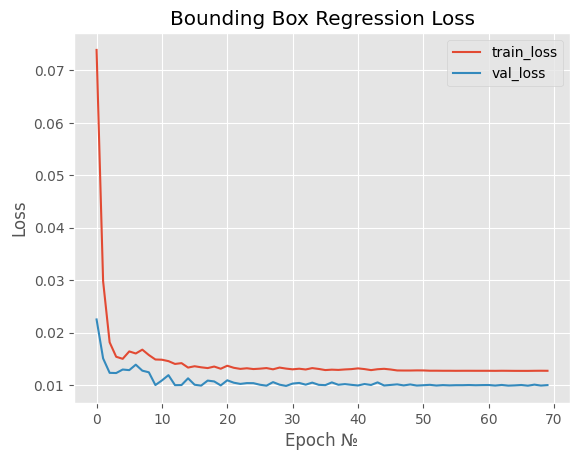

In [ ]:
plt.style.use("ggplot")

plt.figure()

plt.plot(np.arange(0, EPOCHS), 
         H.history["loss"], 
         label="train_loss")

plt.plot(np.arange(0, EPOCHS), 
         H.history["val_loss"], 
         label="val_loss")

plt.title("Bounding Box Regression Loss")
plt.xlabel("Epoch №")
plt.ylabel("Loss")
plt.legend()
plt.savefig("stop_sign_model_loss_plot.png")

In [ ]:
file_names = open("./test_images.txt").read().strip().split("\n")

In [ ]:
img_paths = []

In [ ]:
for f in file_names:
    p = os.path.sep.join([path, f])
    img_paths.append(p)

In [ ]:
model = load_model("./model_stop_signs")

1/1 [==============================] - 1s 708ms/step


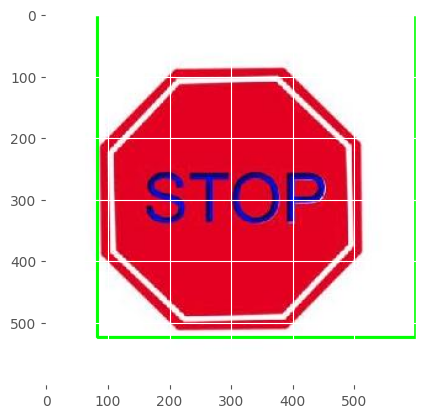

1/1 [==============================] - 0s 29ms/step


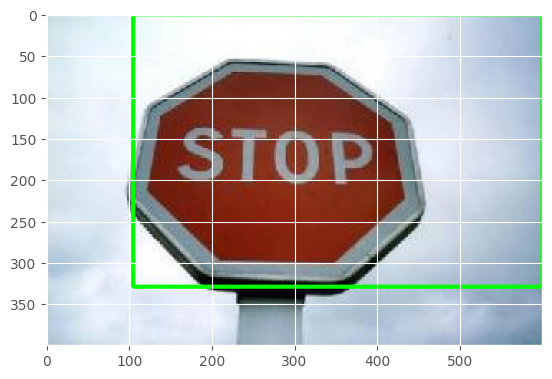

1/1 [==============================] - 0s 31ms/step


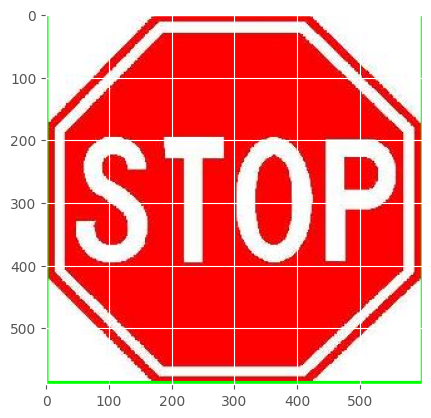

1/1 [==============================] - 0s 35ms/step


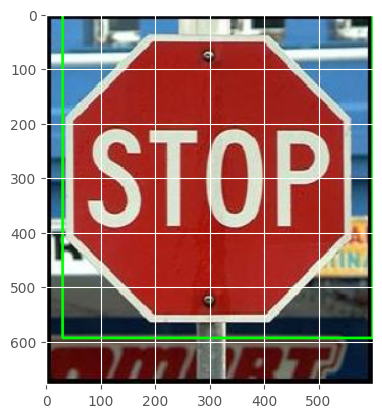

1/1 [==============================] - 0s 45ms/step


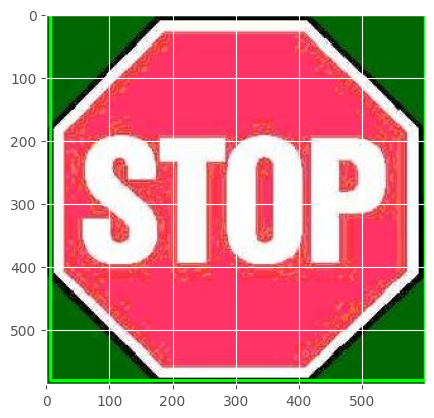

1/1 [==============================] - 0s 35ms/step


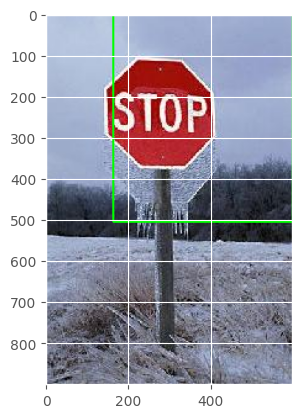

1/1 [==============================] - 0s 28ms/step


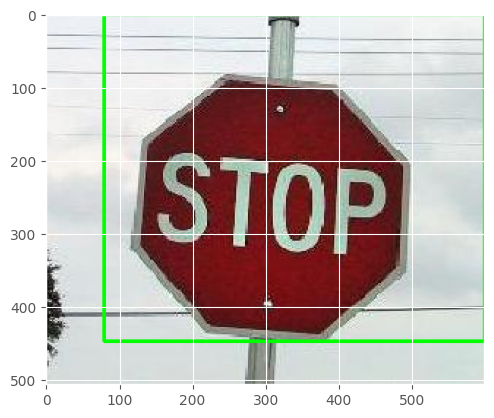

In [ ]:
for img_path in img_paths:
    
    img = load_img(img_path, target_size=(224, 224))

    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    # get the predictions
    preds = model.predict(img)[0]
    
    # load a test image again
    img = cv2.imread(img_path)
    img = imutils.resize(img, width=600)
    (h, w) = img.shape[:2]

    # scale the predicted bounding 
    # box coordinates 
    # based on the img dimensions
    preds[0] = int(preds[0] * w)
    preds[1] = int(preds[1] * h)
    preds[2] = int(preds[2] * w)
    preds[3] = int(preds[3] * h)
    
    # convert predictions to int
    preds = [int(p) for p in preds]

    # draw the predicted bounding box on the img
    cv2.rectangle(img, 
                  (preds[0], preds[1]), 
                  (preds[2], preds[3]), 
                  (0, 255, 0), 3)

    # show the output img
    imgplot = plt.imshow(cv2.cvtColor(img, 
                                      cv2.COLOR_BGR2RGB))
    plt.show()